find path!!


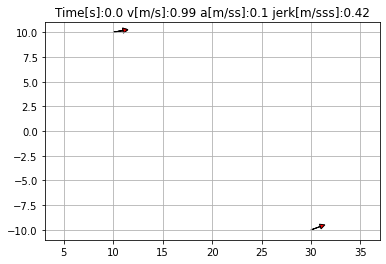

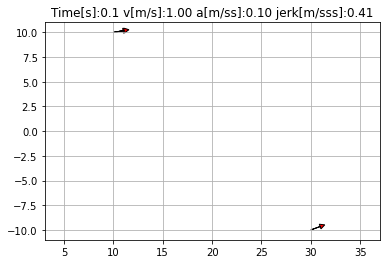

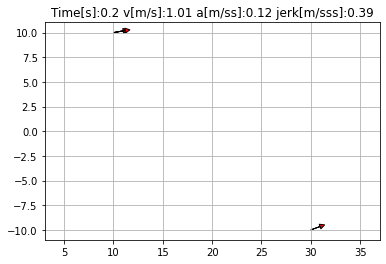

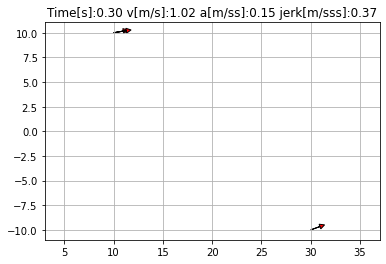

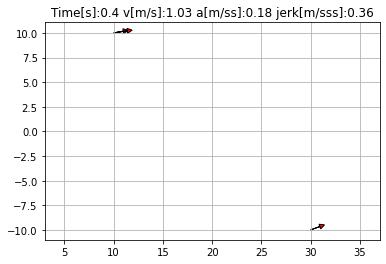

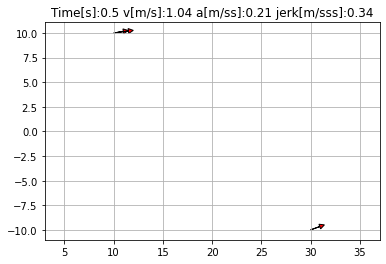

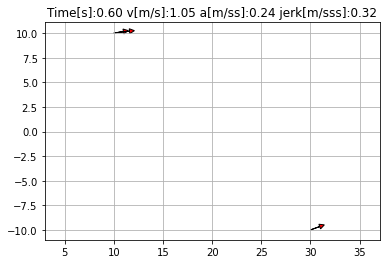

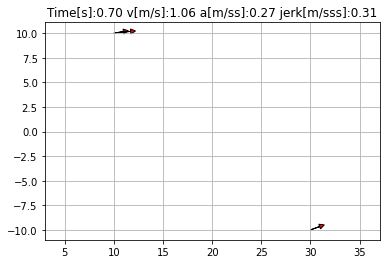

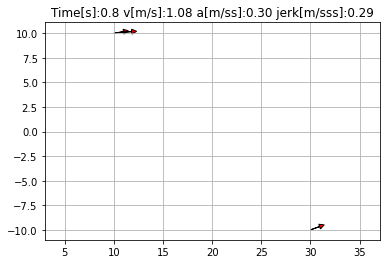

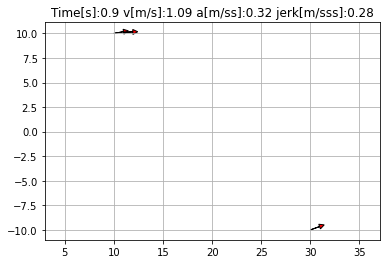

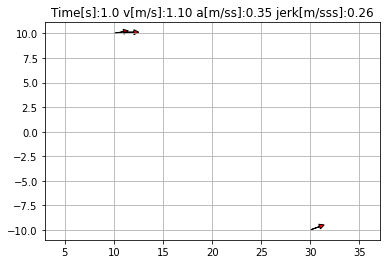

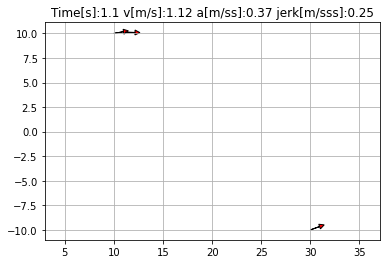

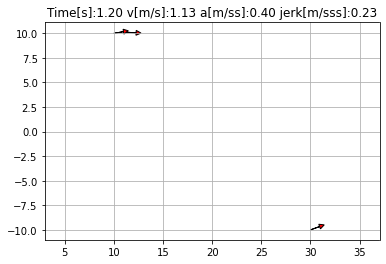

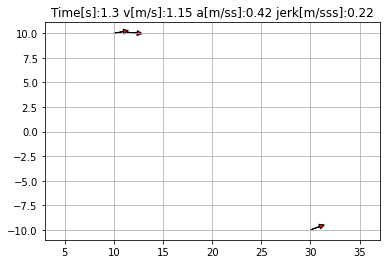

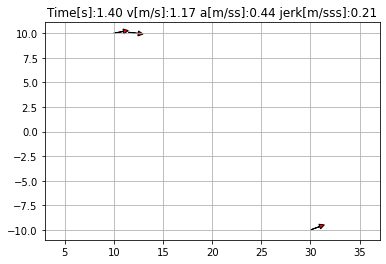

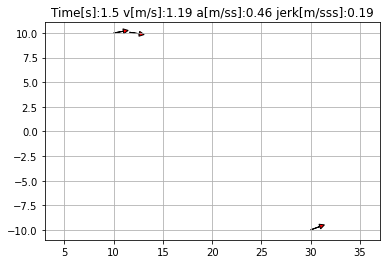

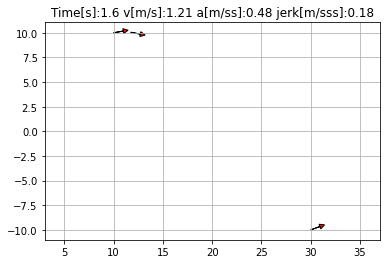

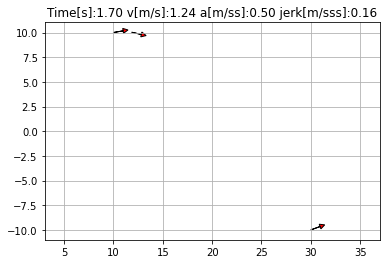

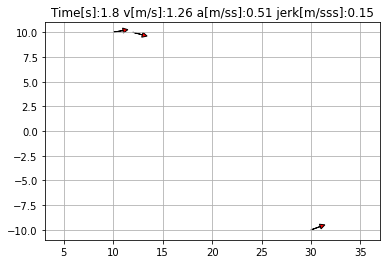

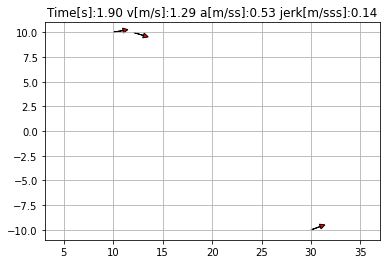

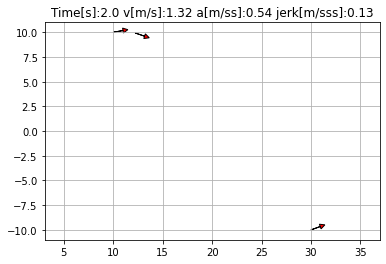

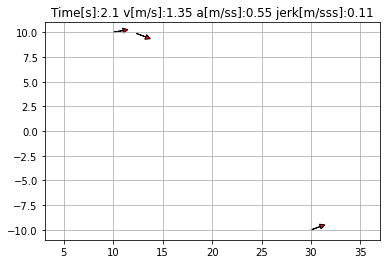

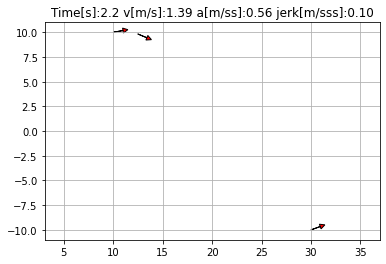

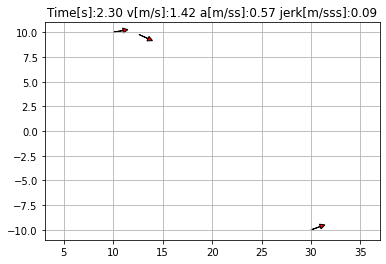

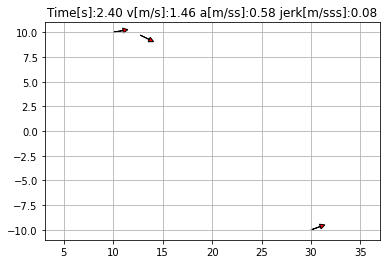

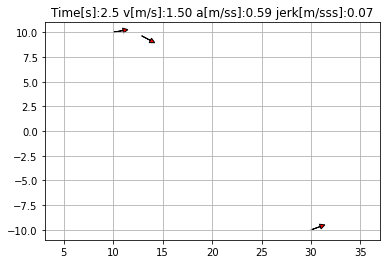

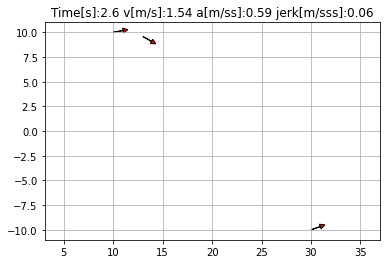

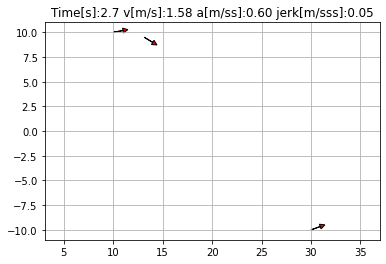

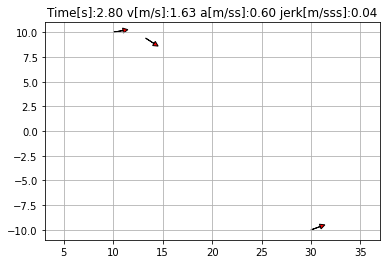

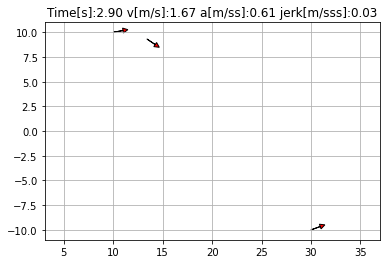

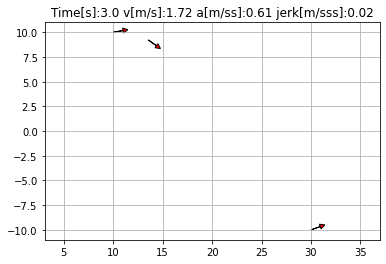

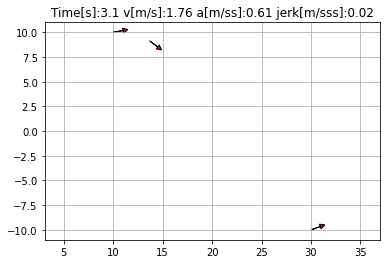

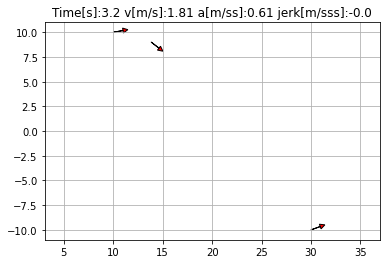

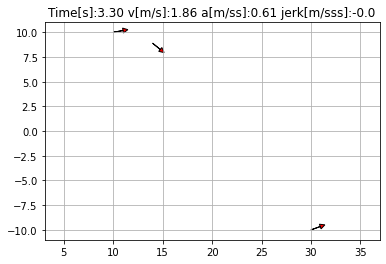

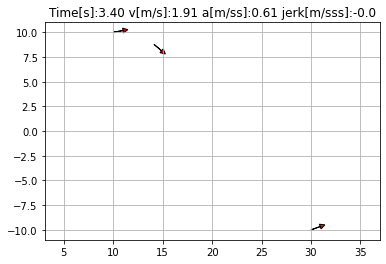

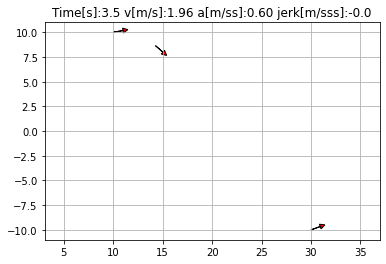

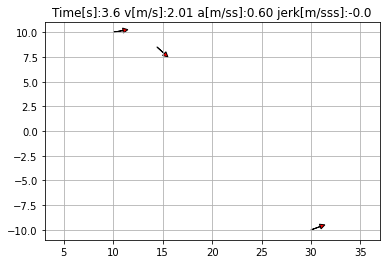

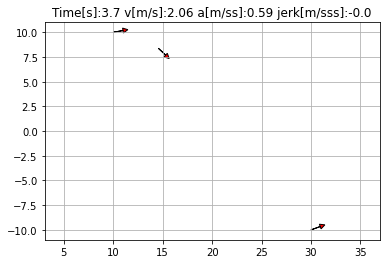

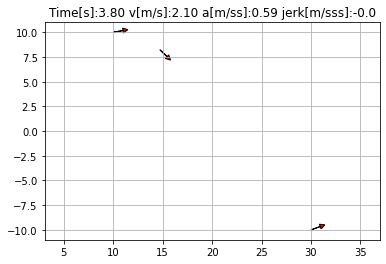

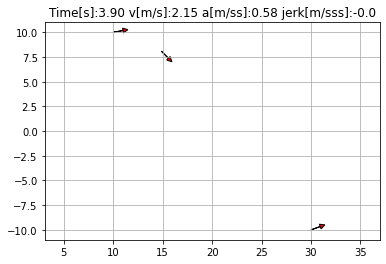

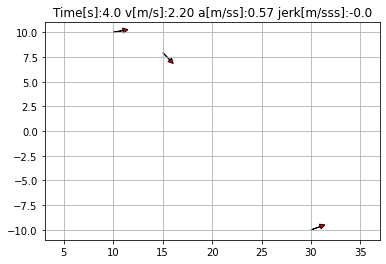

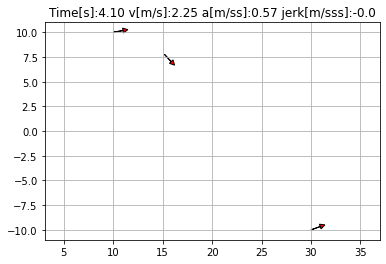

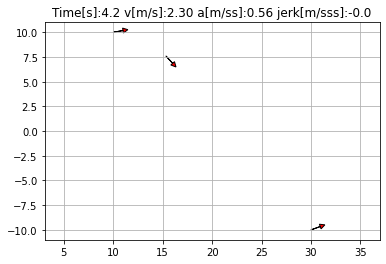

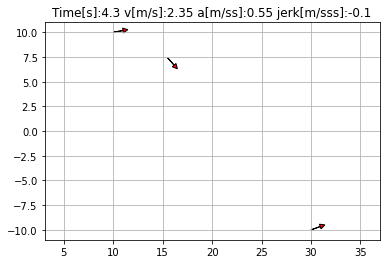

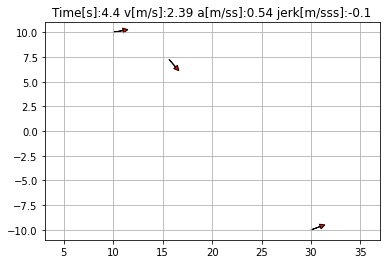

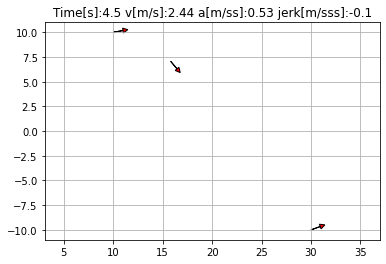

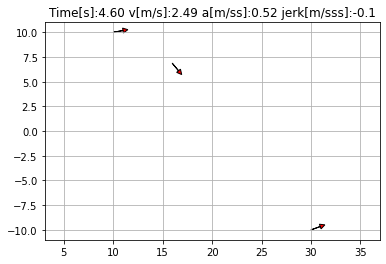

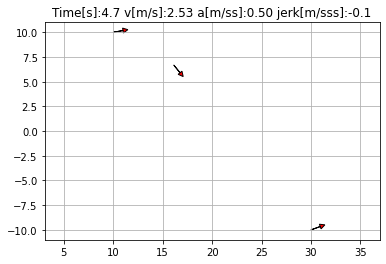

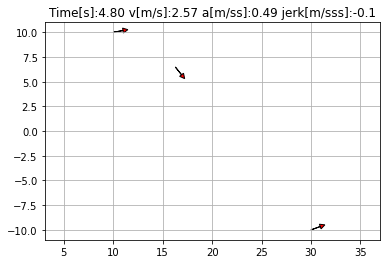

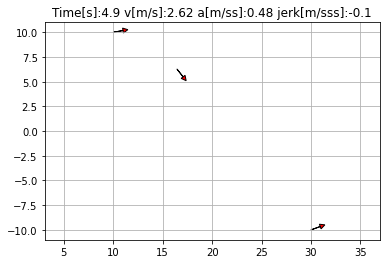

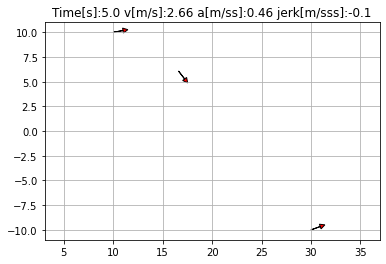

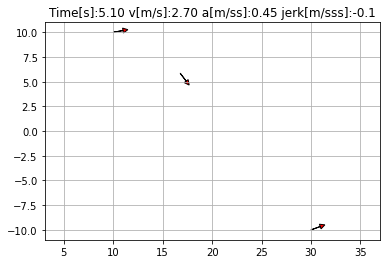

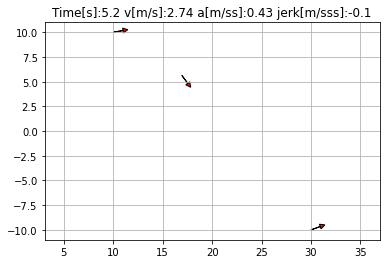

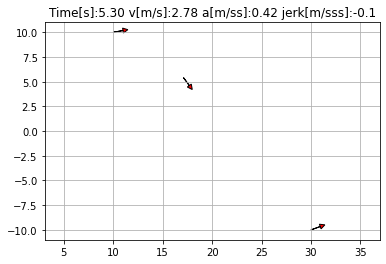

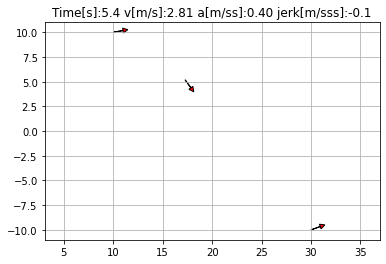

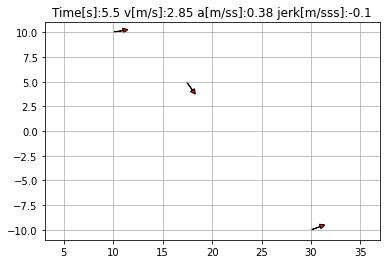

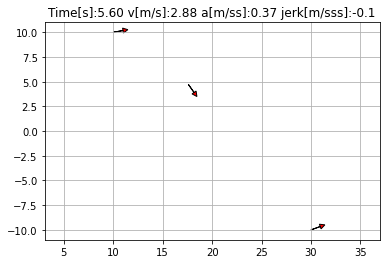

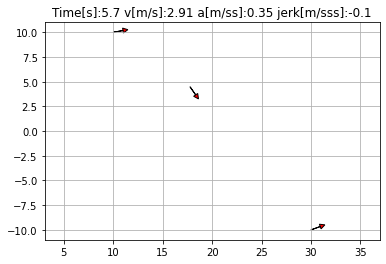

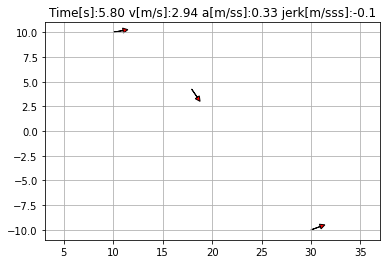

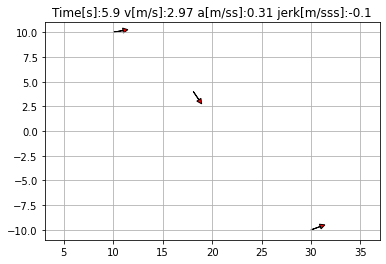

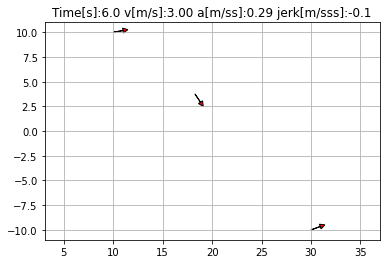

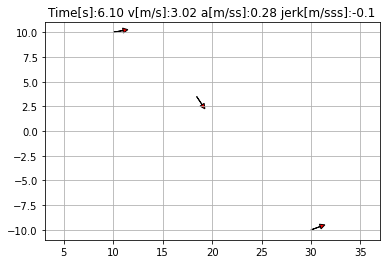

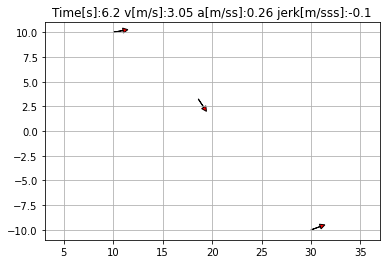

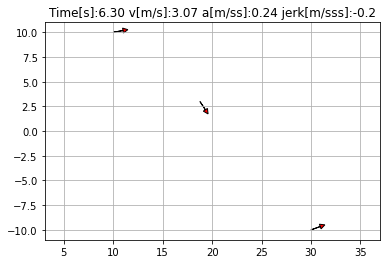

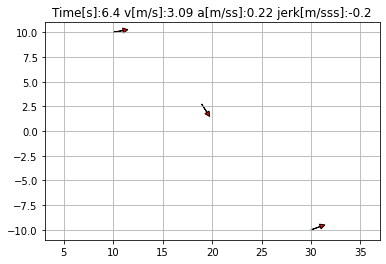

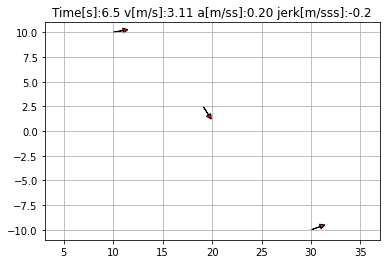

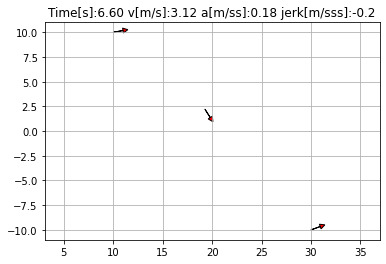

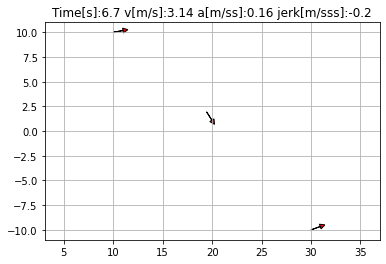

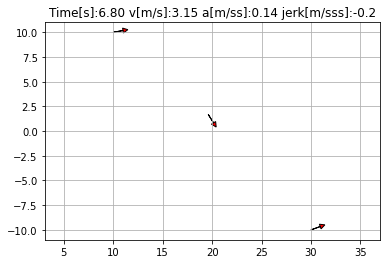

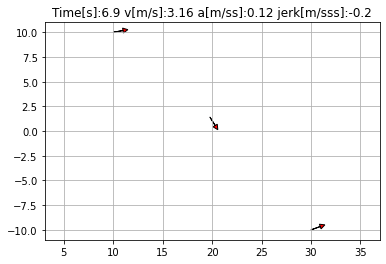

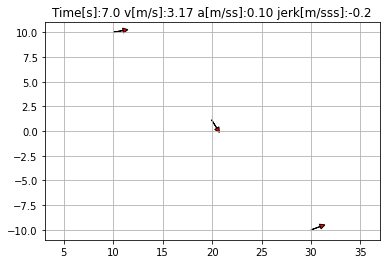

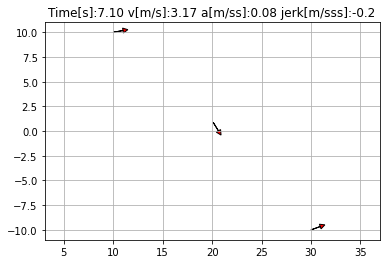

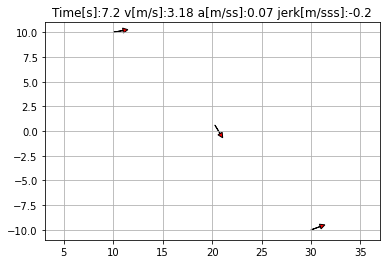

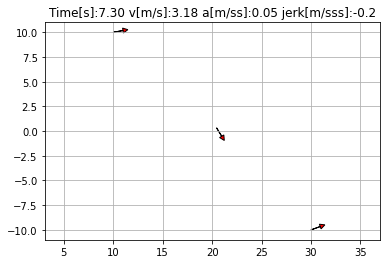

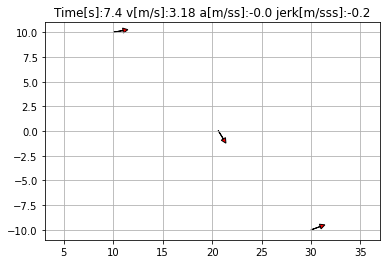

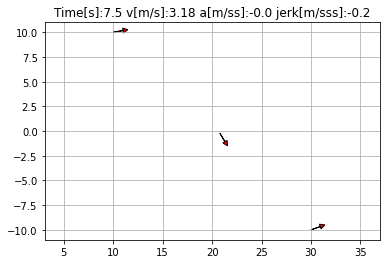

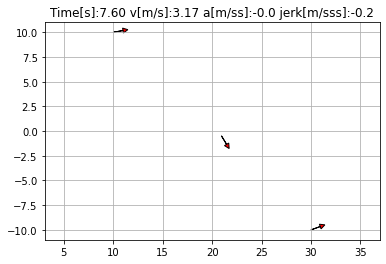

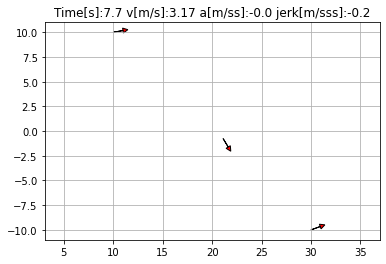

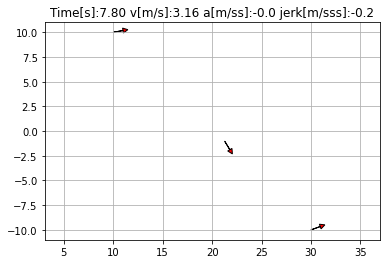

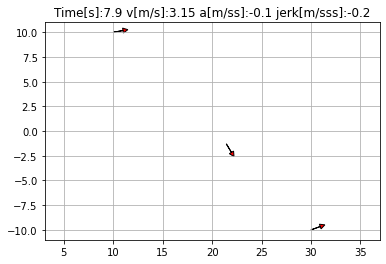

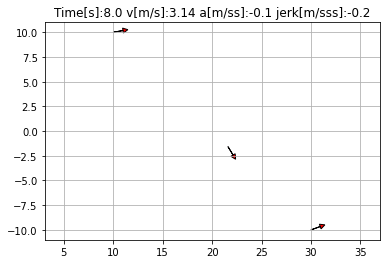

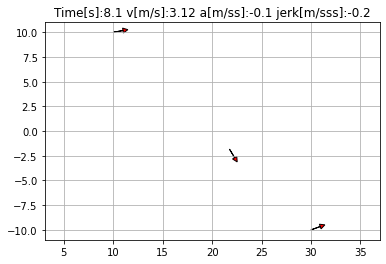

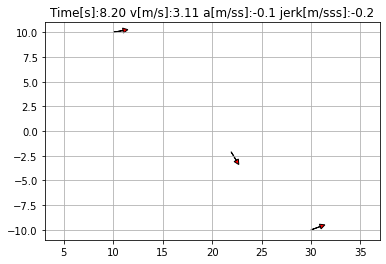

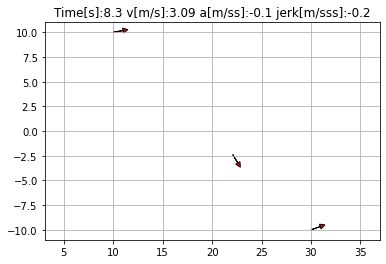

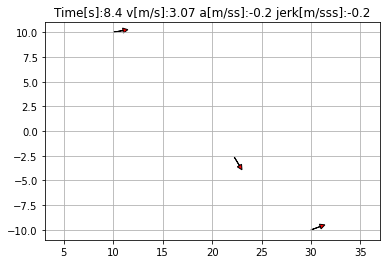

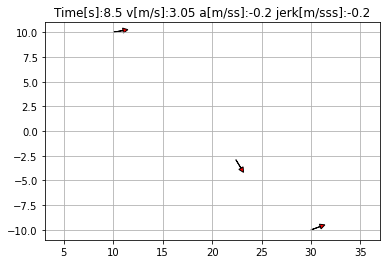

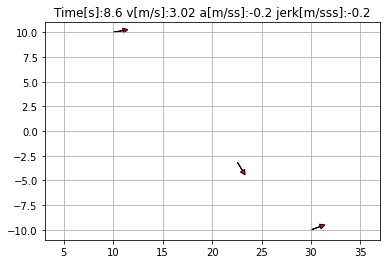

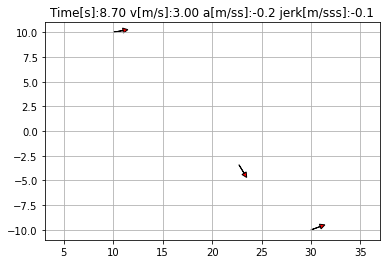

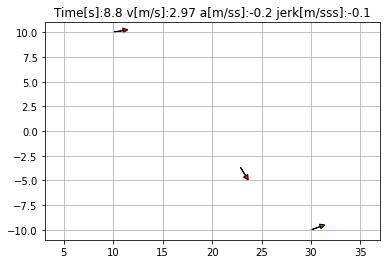

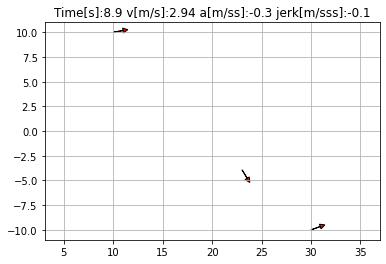

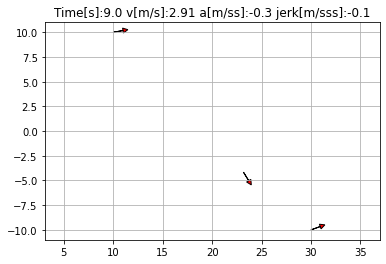

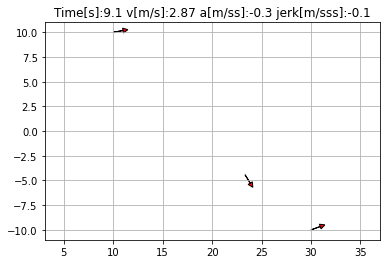

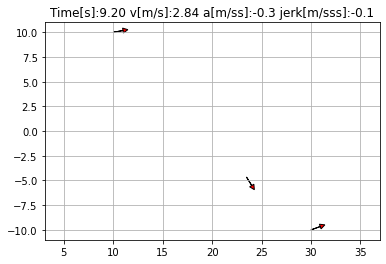

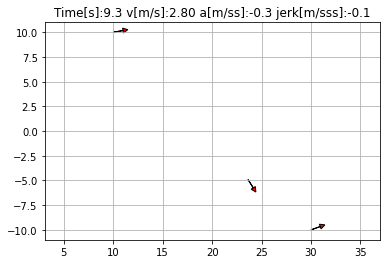

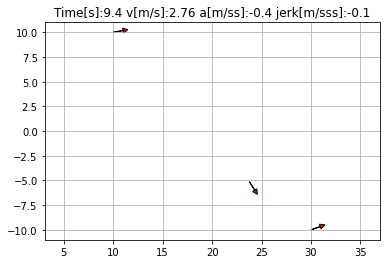

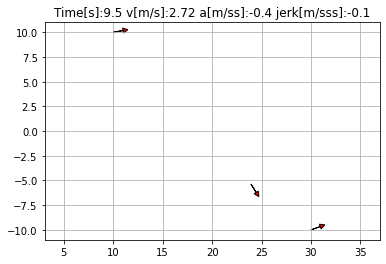

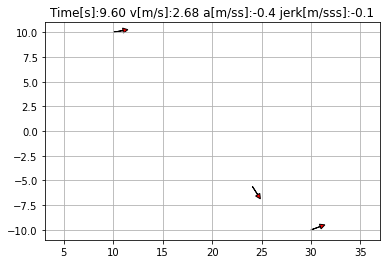

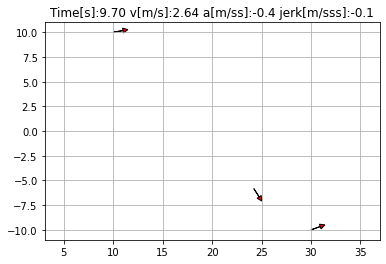

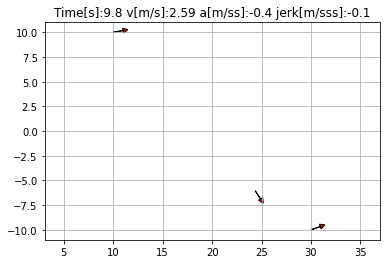

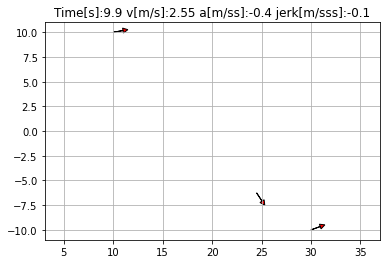

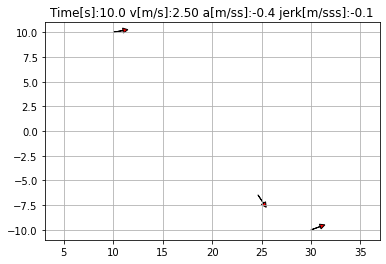

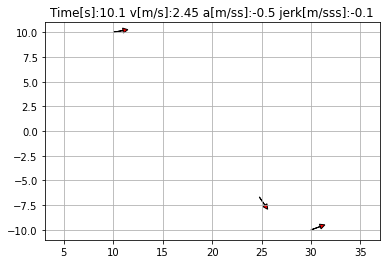

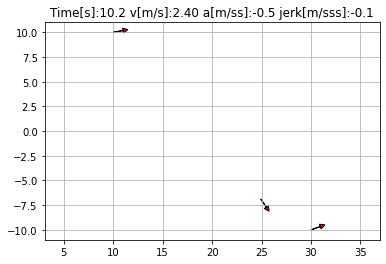

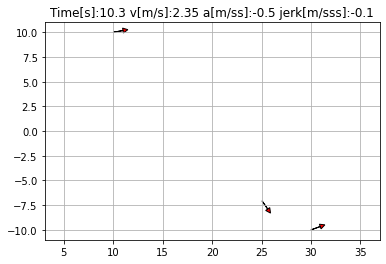

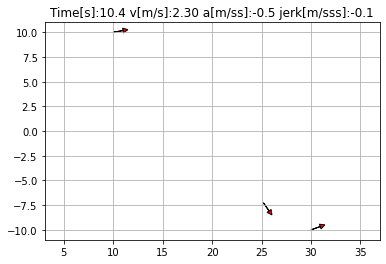

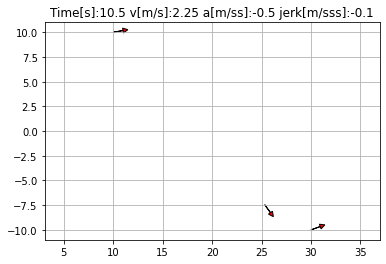

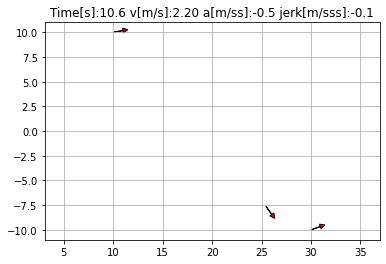

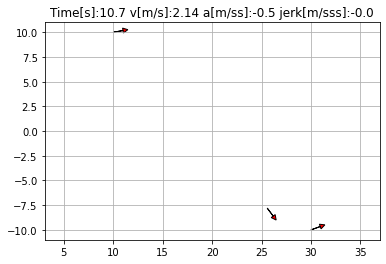

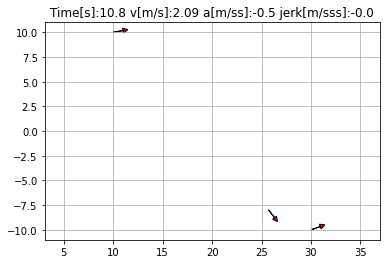

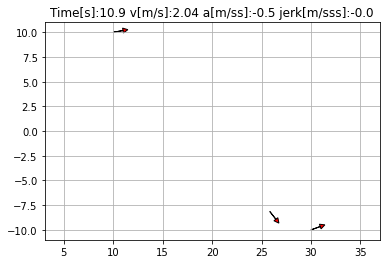

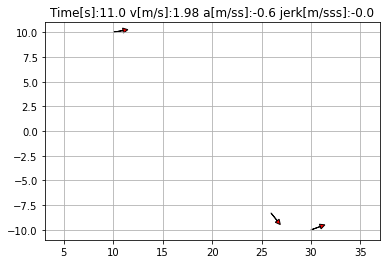

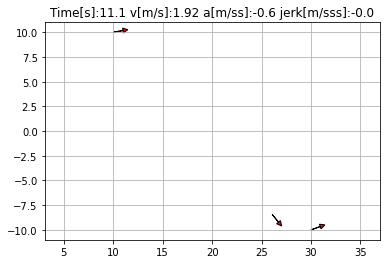

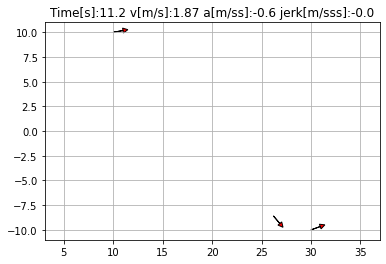

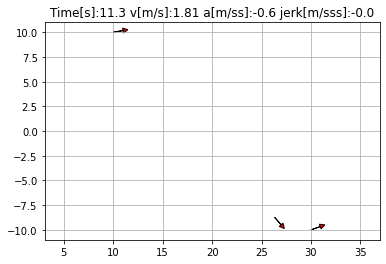

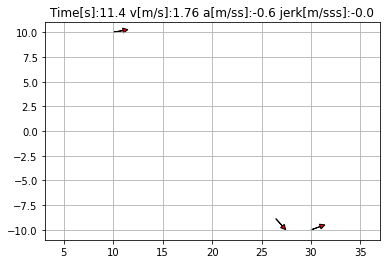

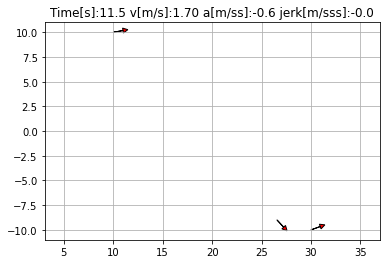

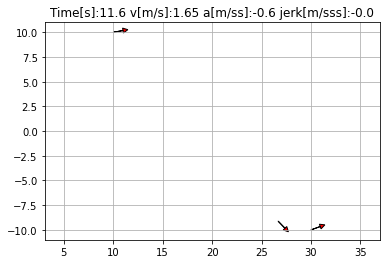

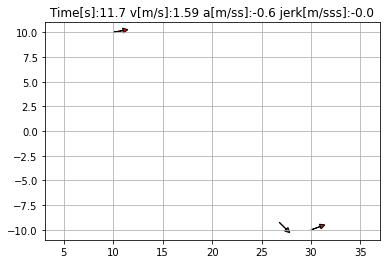

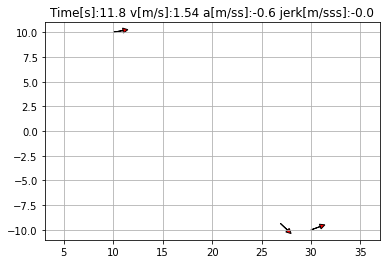

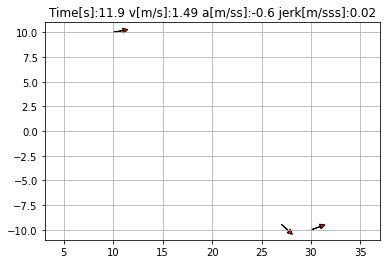

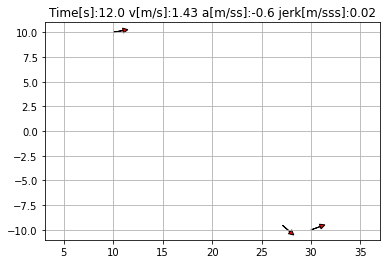

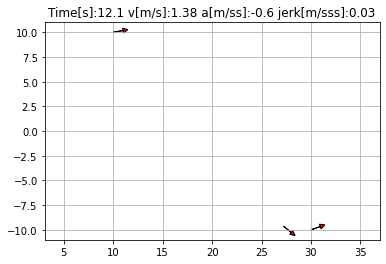

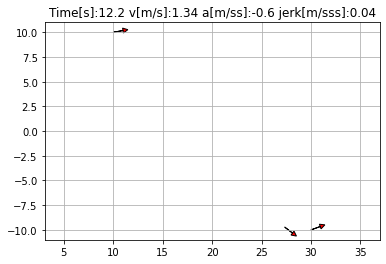

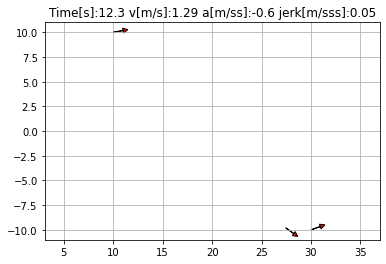

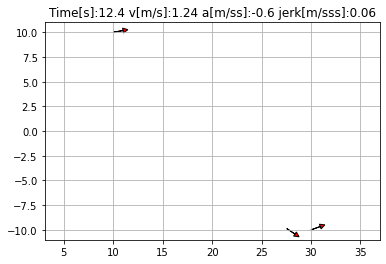

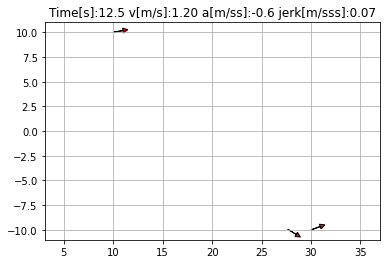

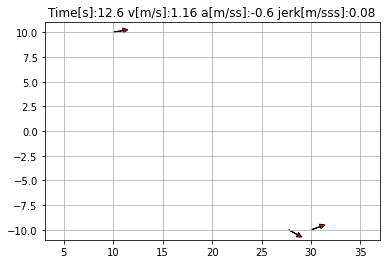

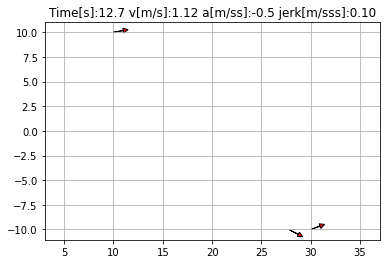

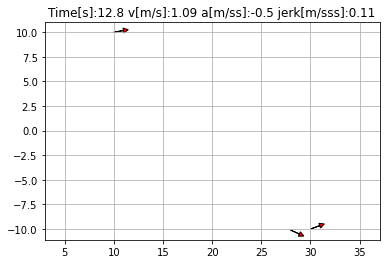

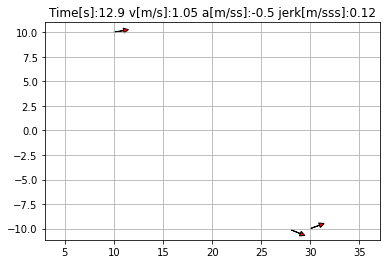

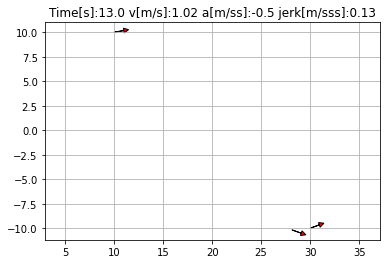

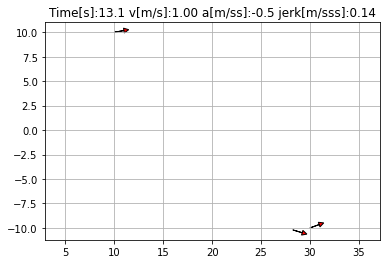

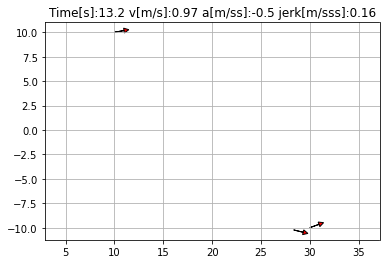

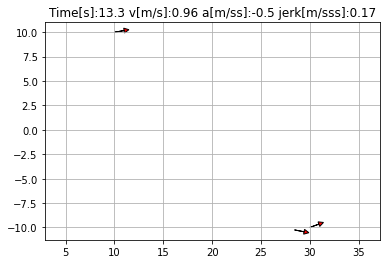

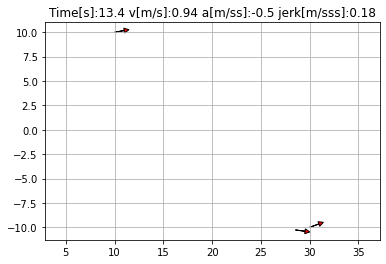

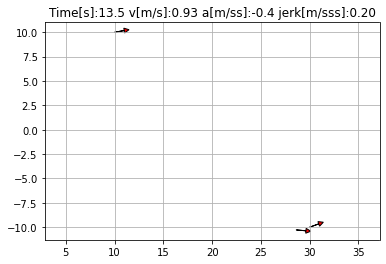

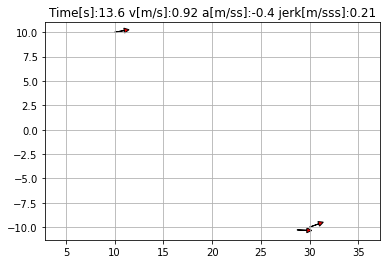

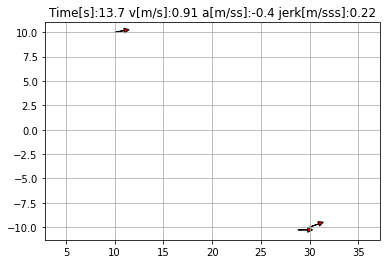

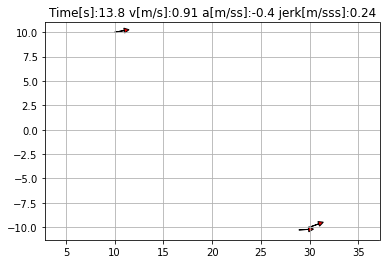

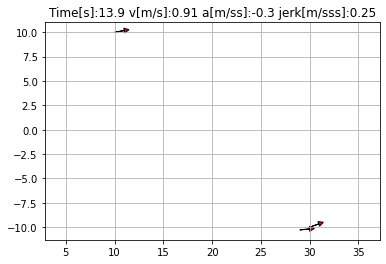

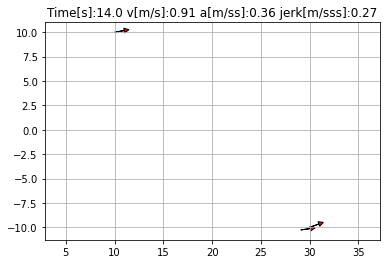

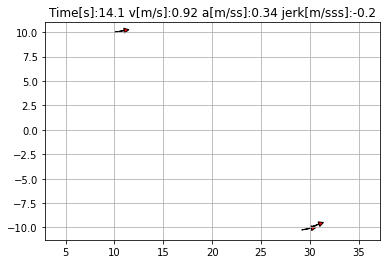

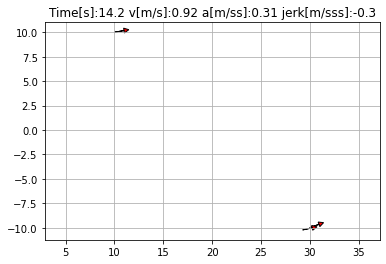

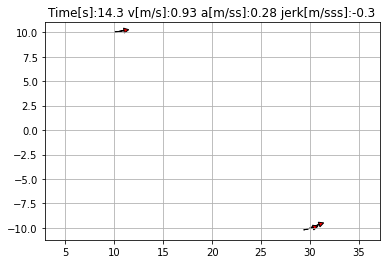

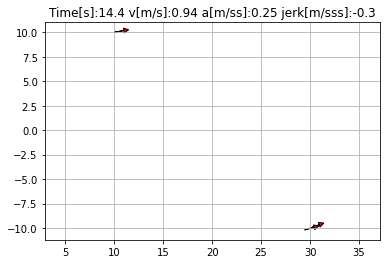

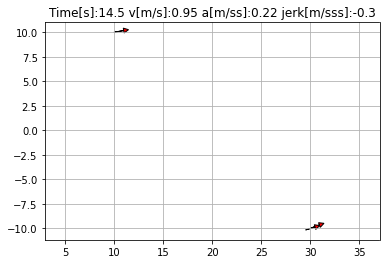

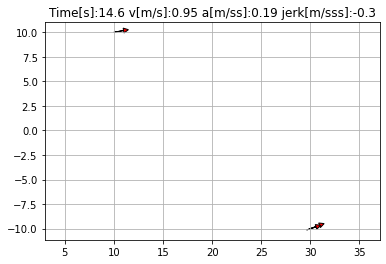

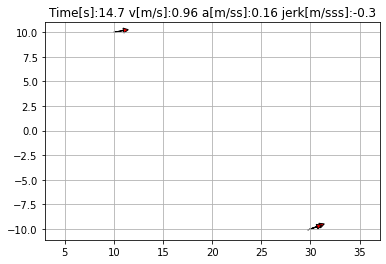

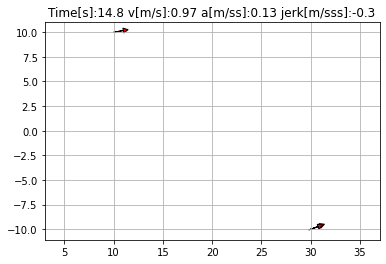

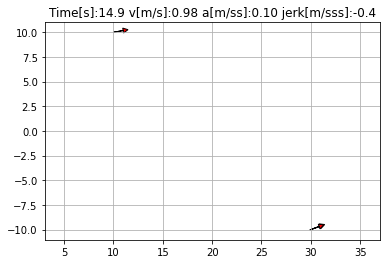

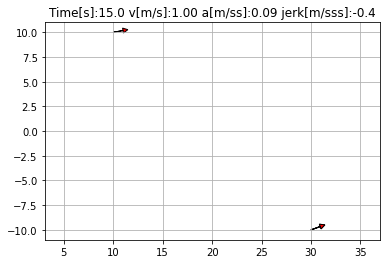

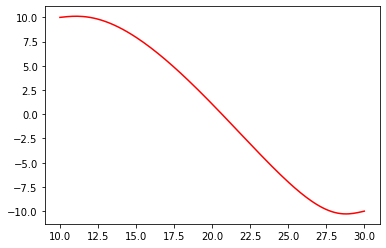

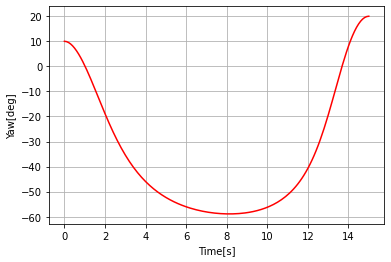

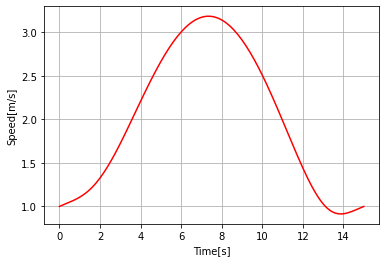

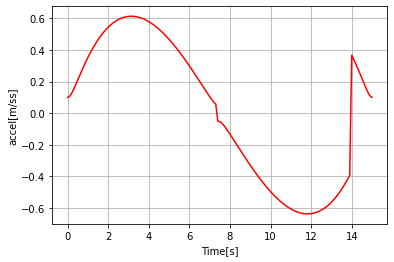

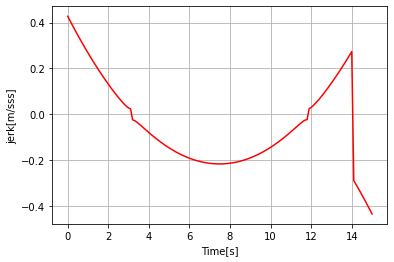

In [2]:
"""
Quintic Polynomials Planner
author: Atsushi Sakai (@Atsushi_twi)
Ref:
- [Local Path planning And Motion Control For Agv In Positioning](http://ieeexplore.ieee.org/document/637936/)
"""

import math

import matplotlib.pyplot as plt
import numpy as np

# parameter
MAX_T = 100.0  # maximum time to the goal [s]
MIN_T = 5.0  # minimum time to the goal[s]

show_animation = True


class QuinticPolynomial:

    def __init__(self, xs, vxs, axs, xe, vxe, axe, time):
        # calc coefficient of quintic polynomial
        # See jupyter notebook document for derivation of this equation.
        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[time ** 3, time ** 4, time ** 5],
                      [3 * time ** 2, 4 * time ** 3, 5 * time ** 4],
                      [6 * time, 12 * time ** 2, 20 * time ** 3]])
        b = np.array([xe - self.a0 - self.a1 * time - self.a2 * time ** 2,
                      vxe - self.a1 - 2 * self.a2 * time,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]
        self.a5 = x[2]

    def calc_point(self, t):
        xt = self.a0 + self.a1 * t + self.a2 * t ** 2 + \
             self.a3 * t ** 3 + self.a4 * t ** 4 + self.a5 * t ** 5

        return xt

    def calc_first_derivative(self, t):
        xt = self.a1 + 2 * self.a2 * t + \
             3 * self.a3 * t ** 2 + 4 * self.a4 * t ** 3 + 5 * self.a5 * t ** 4

        return xt

    def calc_second_derivative(self, t):
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t ** 2 + 20 * self.a5 * t ** 3

        return xt

    def calc_third_derivative(self, t):
        xt = 6 * self.a3 + 24 * self.a4 * t + 60 * self.a5 * t ** 2

        return xt


def quintic_polynomials_planner(sx, sy, syaw, sv, sa, gx, gy, gyaw, gv, ga, max_accel, max_jerk, dt):
    """
    quintic polynomial planner
    input
        s_x: start x position [m]
        s_y: start y position [m]
        s_yaw: start yaw angle [rad]
        sa: start accel [m/ss]
        gx: goal x position [m]
        gy: goal y position [m]
        gyaw: goal yaw angle [rad]
        ga: goal accel [m/ss]
        max_accel: maximum accel [m/ss]
        max_jerk: maximum jerk [m/sss]
        dt: time tick [s]
    return
        time: time result
        rx: x position result list
        ry: y position result list
        ryaw: yaw angle result list
        rv: velocity result list
        ra: accel result list
    """

    vxs = sv * math.cos(syaw)
    vys = sv * math.sin(syaw)
    vxg = gv * math.cos(gyaw)
    vyg = gv * math.sin(gyaw)

    axs = sa * math.cos(syaw)
    ays = sa * math.sin(syaw)
    axg = ga * math.cos(gyaw)
    ayg = ga * math.sin(gyaw)

    time, rx, ry, ryaw, rv, ra, rj = [], [], [], [], [], [], []

    for T in np.arange(MIN_T, MAX_T, MIN_T):
        xqp = QuinticPolynomial(sx, vxs, axs, gx, vxg, axg, T)
        yqp = QuinticPolynomial(sy, vys, ays, gy, vyg, ayg, T)

        time, rx, ry, ryaw, rv, ra, rj = [], [], [], [], [], [], []

        for t in np.arange(0.0, T + dt, dt):
            time.append(t)
            rx.append(xqp.calc_point(t))
            ry.append(yqp.calc_point(t))

            vx = xqp.calc_first_derivative(t)
            vy = yqp.calc_first_derivative(t)
            v = np.hypot(vx, vy)
            yaw = math.atan2(vy, vx)
            rv.append(v)
            ryaw.append(yaw)

            ax = xqp.calc_second_derivative(t)
            ay = yqp.calc_second_derivative(t)
            a = np.hypot(ax, ay)
            if len(rv) >= 2 and rv[-1] - rv[-2] < 0.0:
                a *= -1
            ra.append(a)

            jx = xqp.calc_third_derivative(t)
            jy = yqp.calc_third_derivative(t)
            j = np.hypot(jx, jy)
            if len(ra) >= 2 and ra[-1] - ra[-2] < 0.0:
                j *= -1
            rj.append(j)

        if max([abs(i) for i in ra]) <= max_accel and max([abs(i) for i in rj]) <= max_jerk:
            print("find path!!")
            break

    if show_animation:  # pragma: no cover
        for i, _ in enumerate(time):
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])
            plt.grid(True)
            plt.axis("equal")
            plot_arrow(sx, sy, syaw)
            plot_arrow(gx, gy, gyaw)
            plot_arrow(rx[i], ry[i], ryaw[i])
            plt.title("Time[s]:" + str(time[i])[0:4] +
                      " v[m/s]:" + str(rv[i])[0:4] +
                      " a[m/ss]:" + str(ra[i])[0:4] +
                      " jerk[m/sss]:" + str(rj[i])[0:4],
                      )
            plt.pause(0.001)

    return time, rx, ry, ryaw, rv, ra, rj


def plot_arrow(x, y, yaw, length=1.0, width=0.5, fc="r", ec="k"):  # pragma: no cover
    """
    Plot arrow
    """

    if not isinstance(x, float):
        for (ix, iy, iyaw) in zip(x, y, yaw):
            plot_arrow(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)


def main():
    # print(__file__ + " start!!")

    sx = 10.0  # start x position [m]
    sy = 10.0  # start y position [m]
    syaw = np.deg2rad(10.0)  # start yaw angle [rad]
    sv = 1.0  # start speed [m/s]
    sa = 0.1  # start accel [m/ss]
    gx = 30.0  # goal x position [m]
    gy = -10.0  # goal y position [m]
    gyaw = np.deg2rad(20.0)  # goal yaw angle [rad]
    gv = 1.0  # goal speed [m/s]
    ga = 0.1  # goal accel [m/ss]
    max_accel = 1.0  # max accel [m/ss]
    max_jerk = 0.5  # max jerk [m/sss]
    dt = 0.1  # time tick [s]

    time, x, y, yaw, v, a, j = quintic_polynomials_planner(
        sx, sy, syaw, sv, sa, gx, gy, gyaw, gv, ga, max_accel, max_jerk, dt)

    if show_animation:  # pragma: no cover
        plt.plot(x, y, "-r")

        plt.subplots()
        plt.plot(time, [np.rad2deg(i) for i in yaw], "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("Yaw[deg]")
        plt.grid(True)

        plt.subplots()
        plt.plot(time, v, "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("Speed[m/s]")
        plt.grid(True)

        plt.subplots()
        plt.plot(time, a, "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("accel[m/ss]")
        plt.grid(True)

        plt.subplots()
        plt.plot(time, j, "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("jerk[m/sss]")
        plt.grid(True)

        plt.show()


if __name__ == '__main__':
    main()
